In [50]:
import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
import figurefirst as fifi
from scipy import signal
from sklearn import preprocessing

In [2]:
%matplotlib inline

In [3]:
fly_1 = flb.NetFly(1551,rootpath='/media/imager/FlyDataD/FlyDB/')
fly_1.open_signals()

In [35]:
fly_2 = flb.NetFly(1530,rootpath='/media/imager/FlyDataD/FlyDB/')
fly_2.open_signals()

In [5]:
#### The following cells are for fly_1 iii3 analysis ####

In [48]:
abf_sp = fly_1.abf_times[1] #abf spike period
ca_frame_in_abf = np.int(0.02/abf_sp) #abf period in abf idxs

#get the idx's where the ca data is aquired
ep_idx = np.where(np.array(fly_1.abf_led_pulse)>1.0)[0]
start = ep_idx[0]+np.int(1.5*ca_frame_in_abf) #the calcium data starts at the end of one trigger period 
stop = ep_idx[-1]+np.int(1.5*ca_frame_in_abf)

#make a time array for the recording epoch
ep_times = np.array(fly_1.abf_times[start:stop])
ep_times -= ep_times[0]

#load this into memory since I will use it quite a bit
spike_sig = np.array(fly_1.abf_electrode[start:stop])
left_wing_wsa = np.array(fly_1.abf_kinefly_left[start:stop])
right_wing_wsa = np.array(fly_1.abf_kinefly_right[start:stop])
iii3_ca = fly_1.ca_camera_left_model_fits['iii3']
## another way of extracting b1 activity
#F_ = np.mean(fly.ca_camera_left[:,24:34,75:100],axis = (1,2))
#F = np.percentile(F_,0.01)
#DF_F = (F_-F)/F
#b1_ca = DF_F

In [7]:
#put the ca data into the abf timebase
resampled_iii3_ca,resampled_t = signal.resample(iii3_ca,len(ep_times),
                                              np.array(fly_1.ca_camera_left_times))

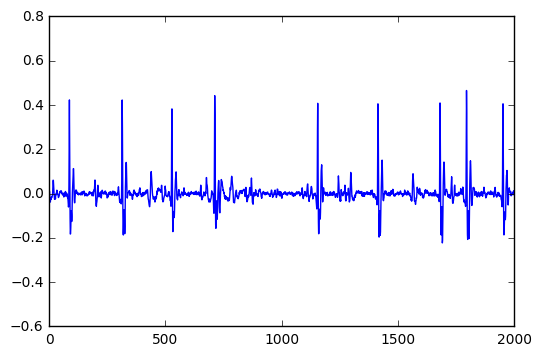

In [112]:
spike_sig_ = spike_sig*-1
filt_sig =flb.util.butter_highpass_filter(data=spike_sig_,
                                          highcut=1000,
                                          order=1,
                                          sampling_period=ep_times[1])
plt.plot(filt_sig)
plt.gca().set_xbound(0,2000)
plt.savefig('iii_3_spikes.pdf')

In [9]:
#grab a spike pool
spike_idxs = flb.util.idx_by_thresh(filt_sig,thresh = 0.2)
#filter out false positives here
#get_peaks
peak_idxs = [np.argmax(spike_sig[idx[0]-10:idx[-1]+10])+idx[0]-10 for idx in spike_idxs]

spike_idxs = spike_idxs[:-1]
peak_idxs = peak_idxs[:-1]

In [10]:
wv_mtrx = np.array([filt_sig[idx-50:idx+50] for idx in peak_idxs])
time_mtrx = np.array([ep_times[idx-50:idx+50] for idx in peak_idxs])

In [11]:
np.shape(wv_mtrx)

(18338, 100)

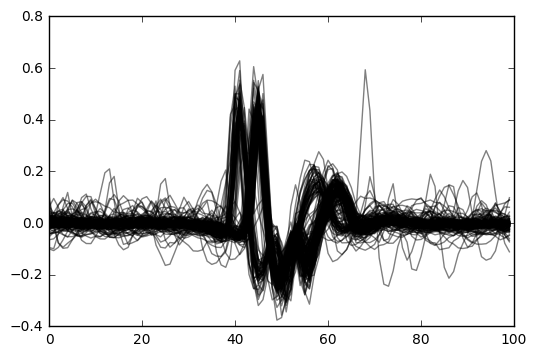

In [114]:
lns = plt.plot(wv_mtrx[::100,:].T,color = 'k', alpha = 0.5)
plt.savefig('iii_waveform.pdf')

In [13]:
from ephystools import spike_sorters as spks
pool = spks.SpikePool(wv_mtrx,time_mtrx)

In [14]:
p2p = spks.P2PTransform(pool,np.ones(len(pool.wv_mtrx)))

In [15]:
p2p.transform()

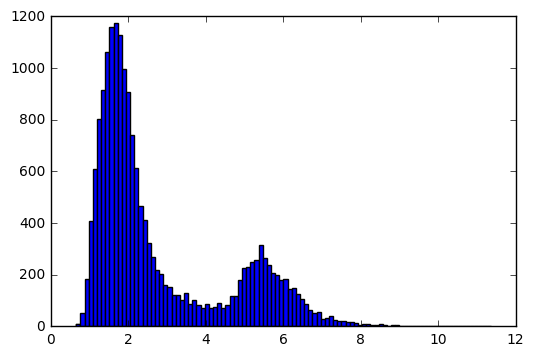

In [16]:
med_trans = spks.MedTrans(pool,
                          np.ones(len(wv_mtrx)),
                          params = {'trans_dims':1})
med_trans.transform()

lns = plt.hist(med_trans.trnsmtrx[:,0],bins = 100)

#plt.gca().set_ybound(0,300)

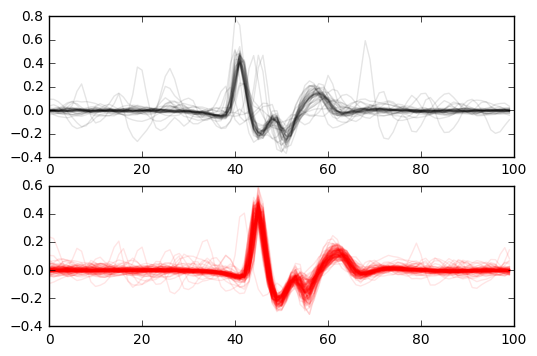

In [116]:
msk =  med_trans.trnsmtrx[:,0]<4.5
plt.subplot(2,1,1)
lns = plt.plot(pool.wv_mtrx[~msk][::100,:].T,color = 'k', alpha = 0.1)
plt.subplot(2,1,2)
lns = plt.plot(pool.wv_mtrx[msk][::100,:].T,color = 'r', alpha = 0.1)
plt.savefig('iii_3_waveforms.pdf')

In [18]:
np.allclose?

Signature: np.allclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)
Docstring:
Returns True if two arrays are element-wise equal within a tolerance.

The tolerance values are positive, typically very small numbers.  The
relative difference (`rtol` * abs(`b`)) and the absolute difference
`atol` are added together to compare against the absolute difference
between `a` and `b`.

If either array contains one or more NaNs, False is returned.
Infs are treated as equal if they are in the same place and of the same
sign in both arrays.

Parameters
----------
a, b : array_like
    Input arrays to compare.
rtol : float
    The relative tolerance parameter (see Notes).
atol : float
    The absolute tolerance parameter (see Notes).
equal_nan : bool
    Whether to compare NaN's as equal.  If True, NaN's in `a` will be
    considered equal to NaN's in `b` in the output array.

    .. versionadded:: 1.10.0

Returns
-------
allclose : bool
    Returns True if the two arrays are equal within the give

In [19]:
spike_freq = np.zeros_like(filt_sig,)
temp_idx = 0
for pi in np.array(peak_idxs)[msk]:
    if ~(temp_idx == pi):
        spike_freq[temp_idx:pi] = 1./((pi-temp_idx)*ep_times[1])
        temp_idx = pi

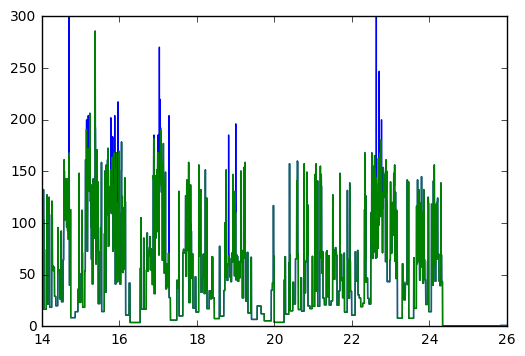

In [20]:
plt.plot(ep_times,spike_freq)
plt.plot(ep_times,signal.medfilt(spike_freq,221))
plt.gca().set_xbound(14,26)
plt.gca().set_ybound(0,300)

In [24]:
spike_freq = signal.medfilt(spike_freq,201)

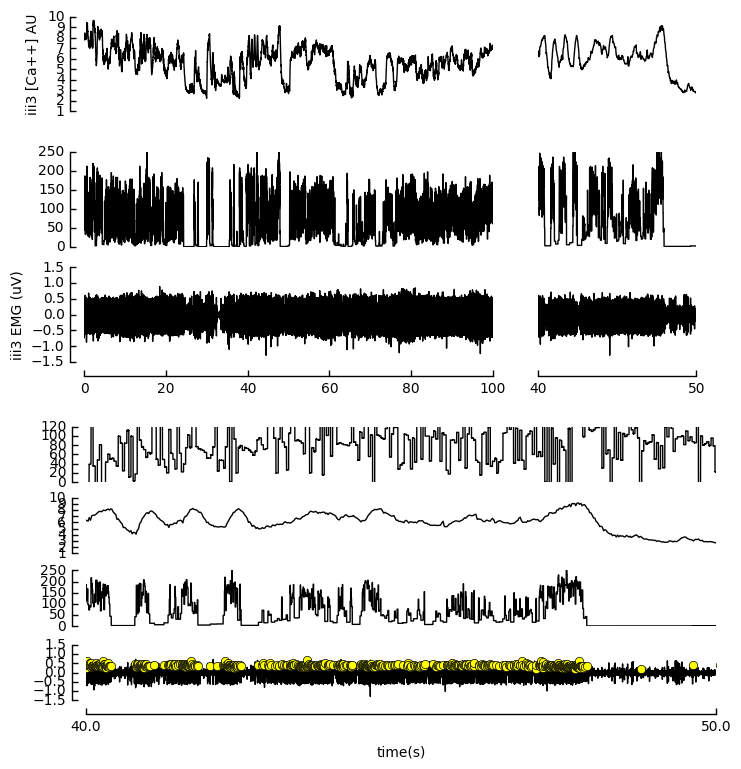

In [118]:
#inspect the data at a several time-scales
muscle_name = 'iii3'

layout = fifi.FigureLayout('inspection_layout_2.svg',make_mplfigures = True)

#layout.axes['ax0'].plot(ep_times,
#                        fly.ca_camera_left_model_fits['i1'],color = 'k')
layout.axes['ax0'].plot(ep_times,spike_freq,color = 'k')
layout.axes['ax0'].set_xbound(0,100)
layout.axes['ax0'].set_ybound(0,220)

layout.axes['ax1'].plot(fly_1.ca_camera_left_times,
                        fly_1.ca_camera_left_model_fits[muscle_name],color = 'k')

layout.axes['ax1'].set_xbound(0,100)
layout.axes['ax1'].set_ylabel('{} [Ca++] AU'.format(muscle_name))
layout.axes['ax2'].plot(ep_times,spike_sig,color = 'k')
layout.axes['ax2'].set_xbound(0,100)
#layout.axes['ax2'].set_ylabel('b1 EMG (%s)'%fly.abf_electrode_units[0])
layout.axes['ax2'].set_ylabel('{} EMG ({})'.format(muscle_name,'uV'))
#WE SHOULD FIGURE OUT WHAT THE UNITS ARE AND ADD IT TO THE AXON PROTOCO

layout.axes['ax0_inset'].plot(ep_times,spike_freq,color = 'k')
layout.axes['ax0_inset'].set_xbound(40,50)
layout.axes['ax0_inset'].set_ybound(0,220)

layout.axes['ax1_inset'].plot(fly_1.ca_camera_left_times,
                              fly_1.ca_camera_left_model_fits[muscle_name],color = 'k')
layout.axes['ax1_inset'].set_xbound(40,50)
layout.axes['ax1_inset'].set_xticks([40,50])


layout.axes['ax2_inset'].plot(ep_times,
                              spike_sig,color = 'k')
layout.axes['ax2_inset'].set_xbound(40,50)
layout.axes['ax2_inset'].set_xticks([40,50])



layout.axes['ax0_inset2'].plot(ep_times,spike_freq,color = 'k')
layout.axes['ax0_inset2'].set_xbound(40,50)
layout.axes['ax0_inset2'].set_ybound(0,220)


layout.axes['ax1_inset2'].plot(fly_1.ca_camera_left_times,
                               fly_1.ca_camera_left_model_fits[muscle_name],color = 'k')
layout.axes['ax1_inset2'].set_xbound(40,50)

layout.axes['ax2_inset2'].plot(ep_times,spike_sig,color = 'k')
layout.axes['ax2_inset2'].plot(ep_times[np.array(peak_idxs)[msk]],
                               spike_sig[np.array(peak_idxs)[msk]],'o',color = 'yellow')

layout.axes['ax2_inset2'].set_xbound(40.0,50.0)
layout.axes['ax2_inset2'].set_xticks([40.0,50.0])
layout.axes['ax2_inset2'].set_xticklabels(['40.0','50.0'])


layout.axes['ax3_inset2'].plot(ep_times,np.rad2deg(right_wing_wsa),color = 'k')
layout.axes['ax3_inset2'].set_ybound(0,120)
layout.axes['ax3_inset2'].set_xbound(40.0,50.0)
layout.axes['ax3_inset2'].set_xticks([40.0,50.0])
layout.axes['ax3_inset2'].set_xticklabels(['40.0','50.0'])


layout.axes['time_label'].set_xlabel('time(s)')
layout.axes['time_label'].set_zorder(-10)
fifi.mpl_functions.set_spines(layout)
layout.save('spikes_vs_ca.svg')

In [25]:
def wiener_deconvolution(signal, kernel, snr):
    "lambd is the SNR"
    from scipy import fft,ifft
    kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + snr**2)))
    return deconvolved

In [28]:
wiener_deconvolution(spike_freq,fly_1.ca_camera_left_model_fits[muscle_name],10.)

array([ 0.64707599,  0.20269261, -0.08990456, ..., -0.1931965 ,
       -0.14803782,  0.12901536])

In [26]:
spike_freq_filt = flb.util.butter_lowpass_filter(data=spike_freq,lowcut=200,order=1,sampling_period=ep_times[1])

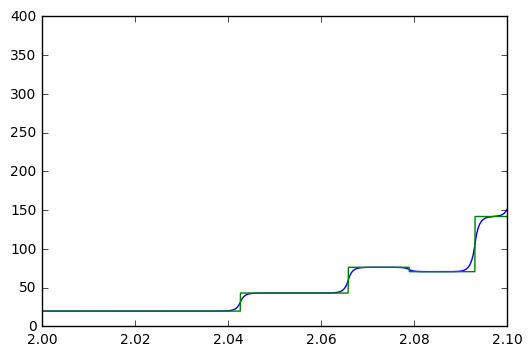

In [27]:
plt.plot(ep_times,spike_freq_filt)
plt.plot(ep_times,spike_freq)
plt.gca().set_xbound(2,2.1)

In [30]:
deconv = wiener_deconvolution(resampled_iii3_ca,spike_freq_filt,snr=2)

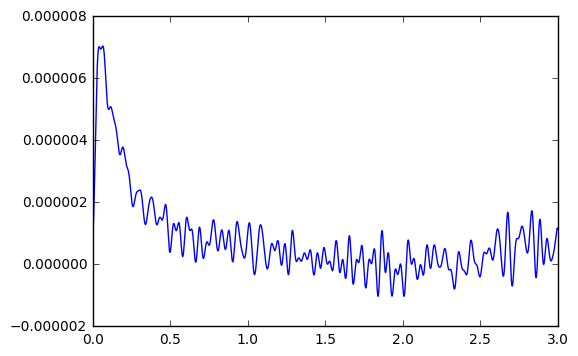

In [31]:
plt.plot(ep_times,deconv)
plt.gca().set_xbound(0,3)

In [32]:
sta_mtrx = [resampled_iii3_ca[x-500:x+20000] for x in peak_idxs[300:-300]]

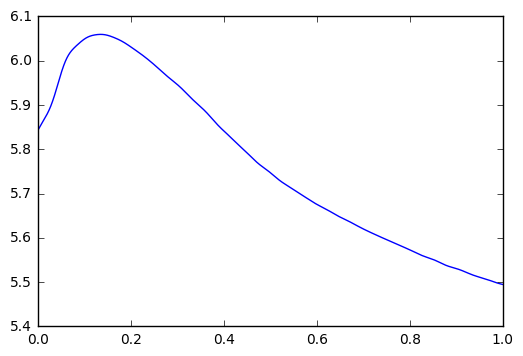

In [119]:
plt.plot(ep_times[:20500],np.mean(sta_mtrx,axis = 0))
plt.gca().set_xbound(0,1)
plt.savefig('iii_3_spike_triggered_average_kernel.pdf')

In [29]:
#### The following are unpacking of i1 kernel for fly2

In [41]:
abf_sp = fly_2.abf_times[1] #abf spike period
ca_frame_in_abf = np.int(0.02/abf_sp) #abf period in abf idxs

#get the idx's where the ca data is aquired
ep_idx = np.where(np.array(fly_2.abf_led_pulse)>1.0)[0]
start = ep_idx[0]+np.int(1.5*ca_frame_in_abf) #the calcium data starts at the end of one trigger period 
stop = ep_idx[-1]+np.int(1.5*ca_frame_in_abf)

#make a time array for the recording epoch
ep_times_2 = np.array(fly_2.abf_times[start:stop])
ep_times_2 -= ep_times_2[0]

#load this into memory since I will use it quite a bit
spike_sig = np.array(fly_2.abf_electrode[start:stop])
i1_ca = fly_2.ca_camera_left_model_fits['i1']
## another way of extracting b1 activity
#F_ = np.mean(fly.ca_camera_left[:,24:34,75:100],axis = (1,2))
#F = np.percentile(F_,0.01)
#DF_F = (F_-F)/F
#b1_ca = DF_F

In [38]:
#put the ca data into the abf timebase
resampled_i1_ca,resampled_t = signal.resample(i1_ca,len(ep_times),
                                              np.array(fly_2.ca_camera_left_times))

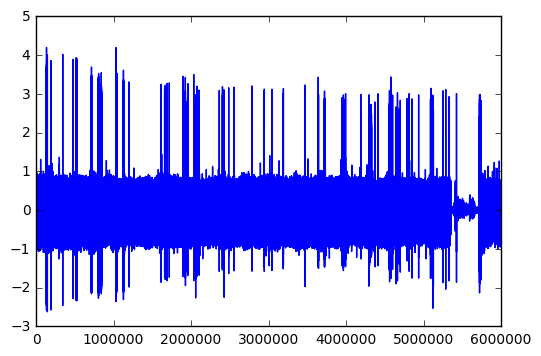

In [39]:
plt.plot(spike_sig*-1)
spike_sig = spike_sig*-1

In [40]:
#grab a spike pool
spike_idxs_2 = flb.util.idx_by_thresh(spike_sig,thresh = 2.5)
#filter out false positives here
#get_peaks
peak_idxs_2 = [np.argmax(spike_sig[idx[0]-10:idx[-1]+10])+idx[0]-10 for idx in spike_idxs_2]

spike_idxs_2 = spike_idxs_2[:-1]
peak_idxs_2 = peak_idxs_2[:-1]

In [42]:
#from thllib import spike_sorters as spks

#wv_mtrx = np.array([spike_sig[idx-50:idx+50] for idx in peak_idxs])
time_mtrx = np.array([ep_times[idx-50:idx+50] for idx in peak_idxs_2])

#lns = plt.plot(wv_mtrx[::10].T)

#pool = spks.SpikePool(wv_mtrx,time_mtrx)

#p2p = spks.P2PTransform(pool,np.ones(len(pool.wv_mtrx)))

#p2p.transform()

#bns = plt.hist(p2p.trnsmtrx[:,1],bins = np.linspace(-100,100,100))

#msk = (p2p.trnsmtrx[:,1]>0)
#msk = (p2p.trnsmtrx[:,1]<20) & (p2p.trnsmtrx[:,1]>0)

#plt.subplot(1,2,1)
#plt.plot(pool.wv_mtrx[msk][::5,:].T,color = 'k', alpha = 0.2)
#plt.subplot(1,2,2)
#lns = plt.plot(pool.wv_mtrx[~msk][::5,:].T,color = 'k', alpha = 0.2)

#med_trans = spks.MedTrans(pool,msk,params = {'trans_dims':1})

#med_trans.transform()

#lns = plt.hist(med_trans.trnsmtrx[:,0],bins = 100)
#plt.gca().set_ybound(0,300)

#msk2 = med_trans.trnsmtrx[:,0]<60.

#plt.subplot(2,1,1)
#lns = plt.plot(pool.wv_mtrx[~(msk & msk2)][:,:].T,color = 'k', alpha = 0.1)
#plt.subplot(2,1,2)
#lns = plt.plot(pool.wv_mtrx[(msk & msk2)][:,:].T,color = 'r', alpha = 0.1)

#lns = plt.plot(np.array([spike_sig[idx-50:idx+50] for idx in peak_idxs[::10]]).T,color = 'k',alpha = 0.2)

#spike_idxs = np.array(spike_idxs)[msk & msk2]
#peak_idxs = np.array(peak_idxs)[msk & msk2]

In [43]:
#create an impulse train to represent the spikes
impulses = np.zeros_like(spike_sig)
impulses[peak_idxs] = 1

In [44]:
kernel = np.real(np.fft.ifft(np.fft.fft(resampled_i1_ca)/np.fft.fft(impulses)))

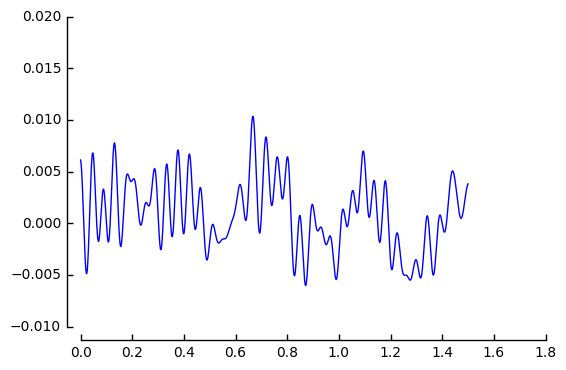

In [45]:
plt.plot(ep_times_2[:30000],kernel[:30000],clip_on = False)
#plt.gca().set_xbound(0,6)
#plt.gca().set_ybound(0,1)
fifi.mpl_functions.adjust_spines(plt.gca(),['left','bottom'])

In [46]:
sta_mtrx_2 = [resampled_i1_ca[x-500:x+20000] for x in peak_idxs_2[10:-10]]
#print(sta_mtrx)
print np.shape(resampled_i1_ca)
print np.shape(resampled_i1_ca[x-500:x+20000])
print np.shape(peak_idxs_2)


(5999983,)
(20500,)
(244,)


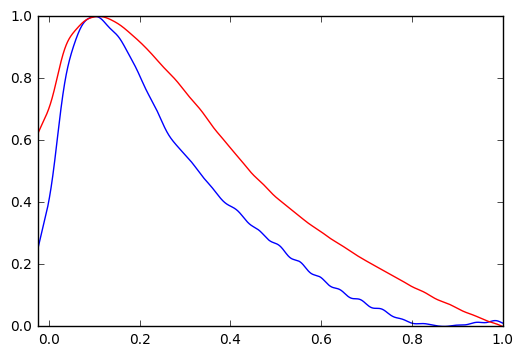

In [122]:
#plt.plot(ep_times_2[:20500],np.mean(sta_mtrx_2,axis = 0))
#plt.gca().set_xbound(0,1)
#plt.plot(ep_times[:20500],np.mean(sta_mtrx,axis = 0))
#plt.gca().set_xbound(0,1)

i1_kernel=np.mean(sta_mtrx_2, axis=0)
iii3_kernel =np.mean(sta_mtrx, axis=0)
zero_padded_kernel =np.hstack((np.zeros_like(iii3_scaled[500:]),iii3_scaled[500:]))

max=1
min=0

#feature_range=(min, max) the full formula is:
i1_kernel_std = (i1_kernel - i1_kernel.min(axis=0)) / (i1_kernel.max(axis=0) - i1_kernel.min(axis=0))
i1_scaled = i1_kernel_std * (max - min) + min
iii3_kernel_std = (iii3_kernel - iii3_kernel.min(axis=0)) / (iii3_kernel.max(axis=0) - iii3_kernel.min(axis=0))
iii3_scaled = iii3_kernel_std * (max - min) + min

plt.plot(ep_times_2[:20500]-ep_times_2[500],i1_scaled, color='b')
plt.gca().set_xbound(0,1)
plt.plot(ep_times[:20500]-ep_times_2[500],iii3_scaled, color='r')
plt.gca().set_xbound(-1*ep_times_2[500],ep_times[20000])
plt.savefig('preliminary_comp_i1_iii_3_spike_triggered_average_kernel.pdf')

In [58]:
spike_train = np.zeros_like(ep_times)

In [62]:
spike_train[peak_idxs]=1
plt.plot(ep_times, spike_train)

In [95]:
convolved_iii3 = scipy.signal.fftconvolve(spike_train, zero_padded_kernel, mode='same')

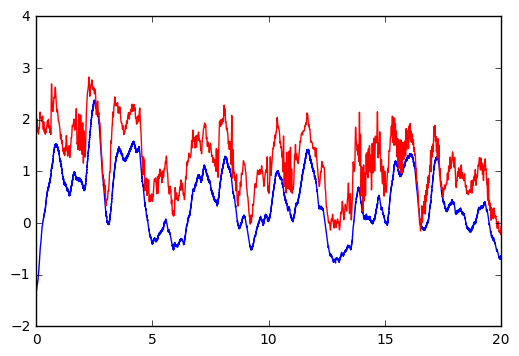

In [123]:
plt.plot(ep_times, preprocessing.scale(convolved_iii3))
#plt.twinx()
plt.plot(ep_times, preprocessing.scale(resampled_iii3_ca), color= 'r')
plt.gca().set_xbound(0,20)
plt.savefig('preliminary_remapping_of_iii3_kernel.pdf')

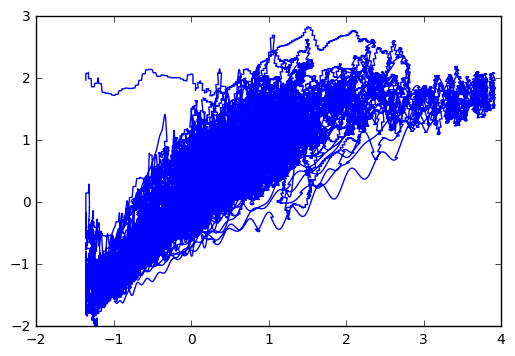

In [124]:
plt.plot(preprocessing.scale(convolved_iii3), preprocessing.scale(resampled_iii3_ca))
plt.savefig('iii3_kernel_linearity.pdf')

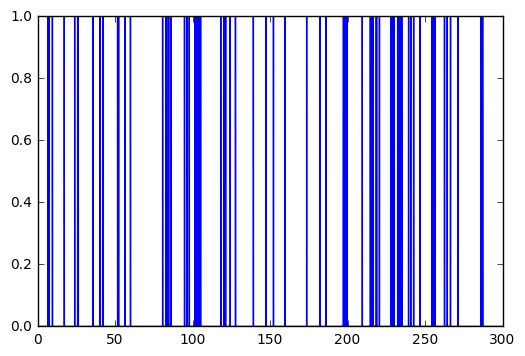

In [127]:
spike_train_i1 = np.zeros_like(ep_times_2)
spike_train_i1[peak_idxs_2]=1
plt.plot(ep_times_2, spike_train_i1)

convolved_iii3_with_i1_spikes = scipy.signal.fftconvolve(spike_train_i1, zero_padded_kernel, mode='same')

(5999983,)
(5999983,)
(5999983,)


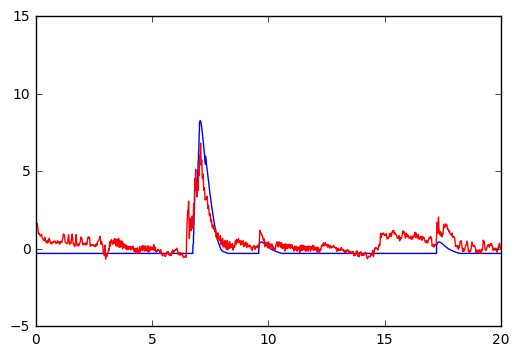

In [131]:
print np.shape(convolved_iii3_with_i1_spikes)
print np.shape(ep_times_2)
print np.shape(resampled_i1_ca)

plt.plot(ep_times_2, preprocessing.scale(convolved_iii3_with_i1_spikes))
#plt.twinx()
plt.plot(ep_times_2, preprocessing.scale(resampled_i1_ca), color= 'r')
plt.gca().set_xbound(0,20)
plt.savefig('preliminary_remapping_of_iii3_kernel_to_i1_spikes.pdf')

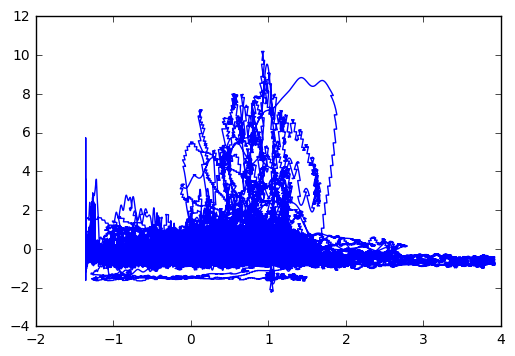

In [110]:
plt.plot(preprocessing.scale(convolved_iii3_with_i1_spikes), preprocessing.scale(resampled_i1_ca[:-2]))

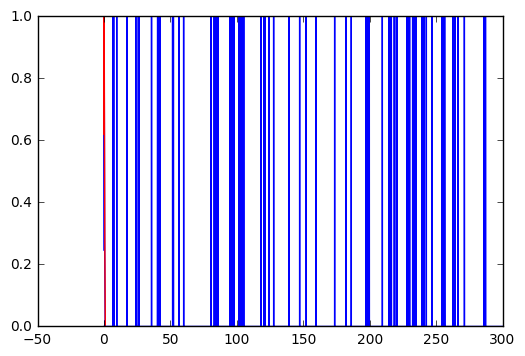

In [136]:
i1_kernel=np.mean(sta_mtrx_2, axis=0)
iii3_kernel =np.mean(sta_mtrx, axis=0)
zero_padded_kernel =np.hstack((np.zeros_like(iii3_scaled[500:]),iii3_scaled[500:]))
zero_padded_kernel_i1 =np.hstack((np.zeros_like(i1_scaled[500:]),i1_scaled[500:]))

max=1
min=0

#feature_range=(min, max) the full formula is:
i1_kernel_std = (i1_kernel - i1_kernel.min(axis=0)) / (i1_kernel.max(axis=0) - i1_kernel.min(axis=0))
i1_scaled = i1_kernel_std * (max - min) + min
iii3_kernel_std = (iii3_kernel - iii3_kernel.min(axis=0)) / (iii3_kernel.max(axis=0) - iii3_kernel.min(axis=0))
iii3_scaled = iii3_kernel_std * (max - min) + min

plt.plot(ep_times_2[:20500]-ep_times_2[500],i1_scaled, color='b')
plt.gca().set_xbound(0,1)
plt.plot(ep_times[:20500]-ep_times_2[500],iii3_scaled, color='r')
plt.gca().set_xbound(-1*ep_times_2[500],ep_times[20000])
plt.savefig('preliminary_comp_i1_iii_3_spike_triggered_average_kernel.pdf')

spike_train_i1 = np.zeros_like(ep_times_2)
spike_train_i1[peak_idxs_2]=1
plt.plot(ep_times_2, spike_train_i1)

convolved_i1_with_iii3_spikes = scipy.signal.fftconvolve(spike_train, zero_padded_kernel_i1, mode='same')
convolved_i1_with_iii3_spikes_2 = scipy.signal.fftconvolve(spike_train, zero_padded_kernel_i1, mode='same')

In [1]:
plt.plot(ep_times, preprocessing.scale(convolved_i1_with_iii3_spikes))
#plt.twinx()
plt.plot(ep_times, preprocessing.scale(resampled_iii3_ca), color= 'r')
plt.gca().set_xbound(0,20)
plt.savefig('preliminary_remapping_of_i1_kernel_to_iii3_spikes.pdf')



NameError: name 'plt' is not defined

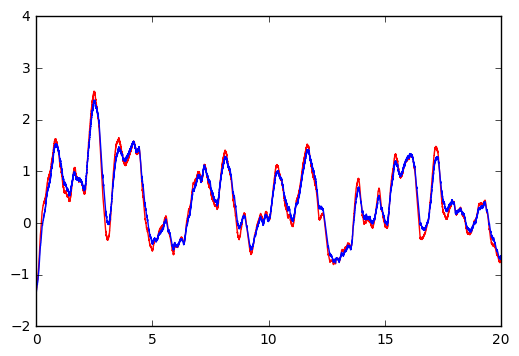

In [144]:
plt.plot(ep_times, preprocessing.scale(convolved_i1_with_iii3_spikes), color='r')
plt.plot(ep_times, preprocessing.scale(convolved_iii3))
plt.gca().set_xbound(0,20)
plt.savefig('iii3_vs_i1_kernel.pdf')